In [320]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import keras
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.applications import VGG19

In [321]:
# setting directory for train, test
train_dir = 'data/train'
test_dir = 'data/test'

In [322]:
# augments image by iteratting through image a
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   brightness_range = [0.9, 1],
                                   validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [323]:
#load data set 
training_generator = train_datagen.flow_from_directory(train_dir, 
                                                target_size = (64,64),
                                                batch_size = 32,
                                                subset = 'training',
                                                seed = 42,
                                                class_mode = 'binary'
                                                )

validation_generator = train_datagen.flow_from_directory(train_dir, 
                                                target_size = (64,64),
                                                batch_size = 32,
                                                subset = 'validation',
                                                seed = 42,
                                                class_mode='binary'
                                                )

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                target_size = (64,64),
                                                batch_size = 32,
                                                seed = 42,
                                                class_mode='binary',
                                                shuffle = False
                                                )

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [324]:
input_shape = (64,64,3)

## Pretrained Modeling

In [325]:
pretrained = VGG19(weights='imagenet',
                   include_top=False,
                   input_shape=input_shape) 

In [326]:
pretrained.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [327]:
model1 = Sequential()
model1.add(pretrained)

# freeze the pretrained layers so they do not learn during fitting
for layer in model1.layers:
    layer.trainable=False 

In [328]:
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(1, activation = 'sigmoid'))
model1.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_35 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_111 (Dense)            (None, 128)               262272    
_________________________________________________________________
dropout_69 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 129       
Total params: 20,286,785
Trainable params: 262,401
Non-trainable params: 20,024,384
_________________________________________________________________


In [329]:
# check if pretrained model's trainability is False
for layer in model1.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_35 True
dense_111 True
dropout_69 True
dense_112 True


In [330]:
model1.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [331]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [332]:
history1 = model1.fit_generator(training_generator,
                             steps_per_epoch=4695//32,
                             epochs =20,
                             validation_data = validation_generator,
                             validation_steps= 521//32,
                             callbacks=[early_stopping])

Epoch 1/20
146/146 [==============================] - 80s 545ms/step - loss: 0.3130 - accuracy: 0.8608 - val_loss: 0.2907 - val_accuracy: 0.8594
Epoch 2/20
146/146 [==============================] - 81s 558ms/step - loss: 0.2263 - accuracy: 0.9044 - val_loss: 0.2625 - val_accuracy: 0.8809
Epoch 3/20
146/146 [==============================] - 76s 519ms/step - loss: 0.1997 - accuracy: 0.9209 - val_loss: 0.2047 - val_accuracy: 0.9160
Epoch 4/20
146/146 [==============================] - 76s 523ms/step - loss: 0.1863 - accuracy: 0.9267 - val_loss: 0.1758 - val_accuracy: 0.9336
Epoch 5/20
146/146 [==============================] - 77s 524ms/step - loss: 0.1830 - accuracy: 0.9237 - val_loss: 0.2029 - val_accuracy: 0.9121
Epoch 6/20
146/146 [==============================] - 76s 524ms/step - loss: 0.1785 - accuracy: 0.9256 - val_loss: 0.2197 - val_accuracy: 0.9102
Epoch 00006: early stopping


In [333]:
history1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

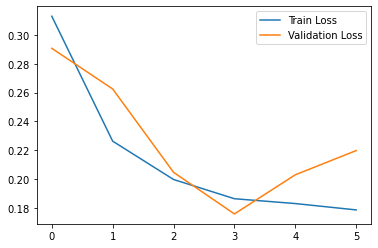

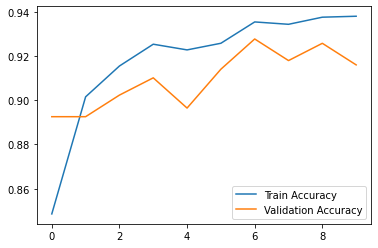

In [334]:
plt.figure()
plt.plot(history1.history["loss"],label = "Train Loss")
plt.plot(history1.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["accuracy"],label = "Train Accuracy")
plt.plot(history.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.show()

## Model 2.0

In [335]:
model2 = Sequential()
model2.add(pretrained)

# freeze the pretrained layers so they do not learn during fitting
for layer in model2.layers:
    layer.trainable=False 

In [336]:
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(1, activation = 'sigmoid'))
model2.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_36 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_113 (Dense)            (None, 128)               262272    
_________________________________________________________________
dropout_70 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_114 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_71 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 128)             

In [337]:
# check if pretrained model's trainability is False
for layer in model.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_34 True
dense_106 True
dropout_65 True
dense_107 True
dropout_66 True
dense_108 True
dropout_67 True
dense_109 True
dropout_68 True
dense_110 True


In [338]:
model2.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [339]:
history2 = model2.fit_generator(training_generator,
                             steps_per_epoch=4695//32,
                             epochs =20,
                             validation_data = validation_generator,
                             validation_steps= 521//32,
                             callbacks=[early_stopping])

Epoch 1/20
146/146 [==============================] - 76s 522ms/step - loss: 0.3869 - accuracy: 0.8274 - val_loss: 0.2617 - val_accuracy: 0.8809
Epoch 2/20
146/146 [==============================] - 76s 517ms/step - loss: 0.2589 - accuracy: 0.8941 - val_loss: 0.2329 - val_accuracy: 0.9043
Epoch 3/20
146/146 [==============================] - 76s 519ms/step - loss: 0.2320 - accuracy: 0.9093 - val_loss: 0.2676 - val_accuracy: 0.8730
Epoch 4/20
146/146 [==============================] - 87s 593ms/step - loss: 0.2267 - accuracy: 0.9059 - val_loss: 0.1846 - val_accuracy: 0.9336
Epoch 5/20
146/146 [==============================] - 88s 600ms/step - loss: 0.2119 - accuracy: 0.9168 - val_loss: 0.2499 - val_accuracy: 0.8867
Epoch 6/20
146/146 [==============================] - 92s 631ms/step - loss: 0.2079 - accuracy: 0.9209 - val_loss: 0.1797 - val_accuracy: 0.9277
Epoch 7/20
146/146 [==============================] - 102s 695ms/step - loss: 0.1949 - accuracy: 0.9230 - val_loss: 0.2059 - val_a

In [340]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

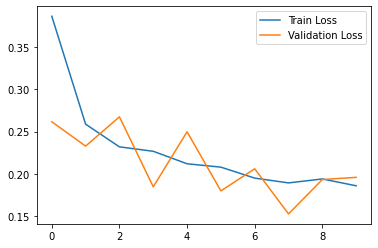

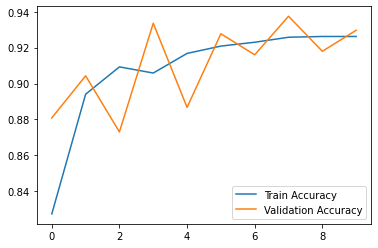

In [341]:
plt.figure()
plt.plot(history2.history["loss"],label = "Train Loss")
plt.plot(history2.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history2.history["accuracy"],label = "Train Accuracy")
plt.plot(history2.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.show()

## Model 3.0

In [342]:
model3 = Sequential()
model3.add(pretrained)

# freeze the pretrained layers so they do not learn during fitting
for layer in model3.layers:
    layer.trainable=False 

In [343]:
pretrained.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [344]:
model3.add(Flatten())
model3.add(Dense(1000, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(1000, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(1000, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(1, activation = 'sigmoid'))
model3.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_37 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_117 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_73 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_118 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dropout_74 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_119 (Dense)            (None, 1000)            

In [345]:
model3.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [346]:
history3 = model3.fit_generator(training_generator,
                             steps_per_epoch=4695//32,
                             epochs =20,
                             validation_data = validation_generator,
                             validation_steps= 521//32,
                             callbacks=[early_stopping])

Epoch 1/20
146/146 [==============================] - 91s 622ms/step - loss: 0.3693 - accuracy: 0.8430 - val_loss: 0.2314 - val_accuracy: 0.9102
Epoch 2/20
146/146 [==============================] - 89s 612ms/step - loss: 0.2309 - accuracy: 0.9020 - val_loss: 0.2285 - val_accuracy: 0.9141
Epoch 3/20
146/146 [==============================] - 87s 599ms/step - loss: 0.2229 - accuracy: 0.9080 - val_loss: 0.1960 - val_accuracy: 0.9121
Epoch 4/20
146/146 [==============================] - 84s 573ms/step - loss: 0.1986 - accuracy: 0.9170 - val_loss: 0.2159 - val_accuracy: 0.8984
Epoch 5/20
146/146 [==============================] - 83s 571ms/step - loss: 0.2047 - accuracy: 0.9181 - val_loss: 0.1807 - val_accuracy: 0.9238
Epoch 6/20
146/146 [==============================] - 84s 573ms/step - loss: 0.1978 - accuracy: 0.9262 - val_loss: 0.2283 - val_accuracy: 0.9023
Epoch 7/20
146/146 [==============================] - 84s 576ms/step - loss: 0.2025 - accuracy: 0.9234 - val_loss: 0.1982 - val_ac

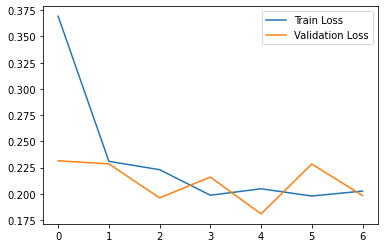

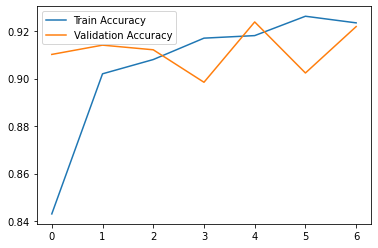

In [347]:
plt.figure()
plt.plot(history3.history["loss"],label = "Train Loss")
plt.plot(history3.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history3.history["accuracy"],label = "Train Accuracy")
plt.plot(history3.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.show()

# Model 4

Fine Tuning 

In [348]:
for i in range (len(pretrained.layers)):
    print (i,pretrained.layers[i])

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002481B62EB20>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002481B62EF40>
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000024819956BE0>
3 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002481B62ECD0>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000248197B5FA0>
5 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002481B623DF0>
6 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002481B61AA60>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002481B611220>
8 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002481B710F10>
9 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002481B6019D0>
10 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002481B5FDEB0>
11 <tensorflow.python.keras.layers.pooling.MaxPooling2D object

In [349]:
for layer in pretrained.layers[17:]:
    layer.trainable=True
for layer in pretrained.layers[0:17]:
    layer.trainable=False

In [350]:
model4 = Sequential()
model4.add(pretrained)

In [351]:
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.4))
model4.add(Dense(1, activation = 'sigmoid'))
model4.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_38 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_121 (Dense)            (None, 128)               262272    
_________________________________________________________________
dropout_76 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 129       
Total params: 20,286,785
Trainable params: 262,401
Non-trainable params: 20,024,384
_________________________________________________________________


In [352]:
for layer in pretrained.layers:
    print(layer.name, layer.trainable)

input_12 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


In [353]:
# check if pretrained model's trainability is False
for layer in model.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_34 True
dense_106 True
dropout_65 True
dense_107 True
dropout_66 True
dense_108 True
dropout_67 True
dense_109 True
dropout_68 True
dense_110 True


In [354]:
model4.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [355]:
history4 = model4.fit_generator(training_generator,
                             steps_per_epoch=4695//32,
                             epochs =20,
                             validation_data = validation_generator,
                             validation_steps= 521//32,
                              callbacks=[early_stopping])

Epoch 1/20
146/146 [==============================] - 85s 585ms/step - loss: 0.3137 - accuracy: 0.8565 - val_loss: 0.2502 - val_accuracy: 0.8867
Epoch 2/20
146/146 [==============================] - 89s 611ms/step - loss: 0.2191 - accuracy: 0.9101 - val_loss: 0.2154 - val_accuracy: 0.9082
Epoch 3/20
146/146 [==============================] - 91s 622ms/step - loss: 0.1972 - accuracy: 0.9234 - val_loss: 0.2078 - val_accuracy: 0.9102
Epoch 4/20
146/146 [==============================] - 89s 609ms/step - loss: 0.1864 - accuracy: 0.9264 - val_loss: 0.1870 - val_accuracy: 0.9277
Epoch 5/20
146/146 [==============================] - 87s 594ms/step - loss: 0.1825 - accuracy: 0.9228 - val_loss: 0.2248 - val_accuracy: 0.8906
Epoch 6/20
146/146 [==============================] - 89s 610ms/step - loss: 0.1914 - accuracy: 0.9215 - val_loss: 0.1997 - val_accuracy: 0.9121
Epoch 00006: early stopping


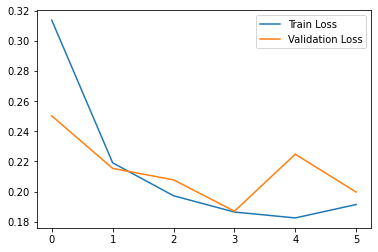

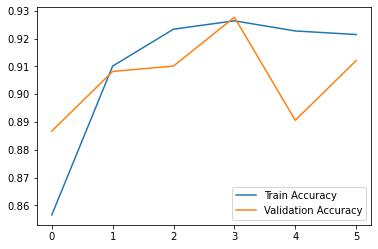

In [357]:
plt.figure()
plt.plot(history4.history["loss"],label = "Train Loss")
plt.plot(history4.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history4.history["accuracy"],label = "Train Accuracy")
plt.plot(history4.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.show()

## Model 5

In [358]:
model5 = Sequential()
model5.add(pretrained)

# freeze the pretrained layers so they do not learn during fitting
for layer in model.layers:
    layer.trainable=False 

In [359]:
model5.add(Flatten())
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.4))
model5.add(Dense(1, activation = 'sigmoid'))
model5.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_39 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_123 (Dense)            (None, 128)               262272    
_________________________________________________________________
dropout_77 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_124 (Dense)            (None, 1)                 129       
Total params: 20,286,785
Trainable params: 262,401
Non-trainable params: 20,024,384
_________________________________________________________________


In [360]:
from keras.optimizers import Adam

model5.compile(loss='binary_crossentropy',
            optimizer= Adam(1e-4),
            metrics=['accuracy'])

In [361]:
history5 = model5.fit_generator(training_generator,
                             steps_per_epoch=4695//32,
                             epochs =20,
                             validation_data = validation_generator,
                             validation_steps= 521//32,
                              callbacks=[early_stopping])

Epoch 1/20
146/146 [==============================] - 91s 625ms/step - loss: 0.4783 - accuracy: 0.7722 - val_loss: 0.3734 - val_accuracy: 0.8301
Epoch 2/20
146/146 [==============================] - 91s 626ms/step - loss: 0.3249 - accuracy: 0.8600 - val_loss: 0.3261 - val_accuracy: 0.8594
Epoch 3/20
146/146 [==============================] - 90s 617ms/step - loss: 0.2776 - accuracy: 0.8833 - val_loss: 0.2736 - val_accuracy: 0.8926
Epoch 4/20
146/146 [==============================] - 89s 613ms/step - loss: 0.2537 - accuracy: 0.8966 - val_loss: 0.2443 - val_accuracy: 0.9062
Epoch 5/20
146/146 [==============================] - 88s 603ms/step - loss: 0.2351 - accuracy: 0.9018 - val_loss: 0.2430 - val_accuracy: 0.8965
Epoch 6/20
146/146 [==============================] - 87s 594ms/step - loss: 0.2229 - accuracy: 0.9101 - val_loss: 0.2293 - val_accuracy: 0.9121
Epoch 7/20
146/146 [==============================] - 90s 618ms/step - loss: 0.2154 - accuracy: 0.9134 - val_loss: 0.2201 - val_ac

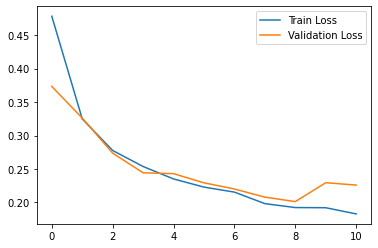

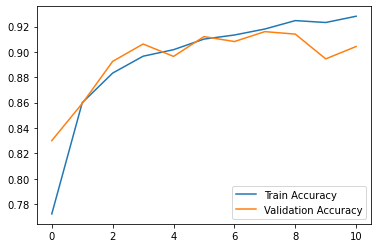

In [362]:
plt.figure()
plt.plot(history5.history["loss"],label = "Train Loss")
plt.plot(history5.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history5.history["accuracy"],label = "Train Accuracy")
plt.plot(history5.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.show()

## Model 6

In [363]:
model6 = Sequential()
model6.add(pretrained)

# freeze the pretrained layers so they do not learn during fitting
for layer in model.layers:
    layer.trainable=False 

In [364]:
model6.add(Flatten())
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.4))
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.4))
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.4))
model6.add(Dense(1, activation = 'sigmoid'))
model6.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_40 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_125 (Dense)            (None, 128)               262272    
_________________________________________________________________
dropout_78 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_79 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_127 (Dense)            (None, 128)             

In [366]:
model6.compile(loss='binary_crossentropy',
            optimizer= Adam(1e-4),
            metrics=['accuracy'])

In [367]:
history6 = model6.fit_generator(training_generator,
                               steps_per_epoch=4695//32,
                               epochs =20,
                               validation_data = validation_generator,
                               validation_steps= 521//32,
                               callbacks=[early_stopping])

Epoch 1/20
146/146 [==============================] - 91s 623ms/step - loss: 0.5999 - accuracy: 0.6852 - val_loss: 0.4867 - val_accuracy: 0.7520
Epoch 2/20
146/146 [==============================] - 90s 616ms/step - loss: 0.4374 - accuracy: 0.7997 - val_loss: 0.3598 - val_accuracy: 0.8398
Epoch 3/20
146/146 [==============================] - 91s 621ms/step - loss: 0.3499 - accuracy: 0.8486 - val_loss: 0.3144 - val_accuracy: 0.8789
Epoch 4/20
146/146 [==============================] - 98s 669ms/step - loss: 0.2982 - accuracy: 0.8784 - val_loss: 0.3052 - val_accuracy: 0.8594
Epoch 5/20
146/146 [==============================] - 100s 684ms/step - loss: 0.2595 - accuracy: 0.8926 - val_loss: 0.2346 - val_accuracy: 0.8965
Epoch 6/20
146/146 [==============================] - 85s 581ms/step - loss: 0.2407 - accuracy: 0.9009 - val_loss: 0.2039 - val_accuracy: 0.9199
Epoch 7/20
146/146 [==============================] - 90s 616ms/step - loss: 0.2234 - accuracy: 0.9146 - val_loss: 0.2097 - val_a

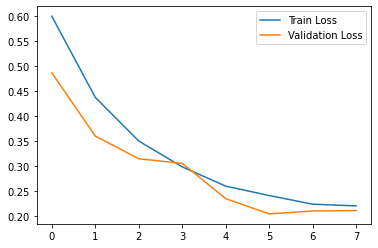

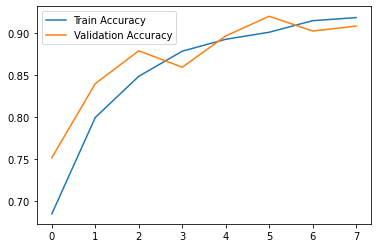

In [368]:
plt.figure()
plt.plot(history6.history["loss"],label = "Train Loss")
plt.plot(history6.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history6.history["accuracy"],label = "Train Accuracy")
plt.plot(history6.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.show()

## Model 7

In [381]:
model7 = Sequential()
model7.add(pretrained)

# freeze the pretrained layers so they do not learn during fitting
for layer in model.layers:
    layer.trainable=False 

In [382]:
model7.add(Flatten())
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.4))
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.4))
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.4))
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.4))
model7.add(Dense(1, activation = 'sigmoid'))
model7.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_41 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_129 (Dense)            (None, 128)               262272    
_________________________________________________________________
dropout_81 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_130 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_82 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 128)             

In [175]:
model7.compile(loss='binary_crossentropy',
            optimizer= Adam(1e-4),
            metrics=['accuracy'])

In [177]:
history7 = model7.fit_generator(training_generator,
                               steps_per_epoch=4695//32,
                               epochs =20,
                               validation_data = validation_generator,
                               validation_steps= 521//32#,
                               #callbacks=[early_stopping]
                              )

Epoch 1/20
146/146 [==============================] - 100s 682ms/step - loss: 0.6183 - accuracy: 0.6646 - val_loss: 0.5057 - val_accuracy: 0.7402
Epoch 2/20
146/146 [==============================] - 136s 932ms/step - loss: 0.4729 - accuracy: 0.7628 - val_loss: 0.4029 - val_accuracy: 0.8184
Epoch 3/20
146/146 [==============================] - 121s 826ms/step - loss: 0.3828 - accuracy: 0.8160 - val_loss: 0.3328 - val_accuracy: 0.8438
Epoch 4/20
146/146 [==============================] - 149s 1s/step - loss: 0.3156 - accuracy: 0.8679 - val_loss: 0.2852 - val_accuracy: 0.8789
Epoch 5/20
146/146 [==============================] - 155s 1s/step - loss: 0.2759 - accuracy: 0.8881 - val_loss: 0.2475 - val_accuracy: 0.8945
Epoch 6/20
146/146 [==============================] - 127s 869ms/step - loss: 0.2345 - accuracy: 0.9082 - val_loss: 0.2251 - val_accuracy: 0.9082
Epoch 7/20
146/146 [==============================] - 83s 565ms/step - loss: 0.2193 - accuracy: 0.9134 - val_loss: 0.2247 - val_ac

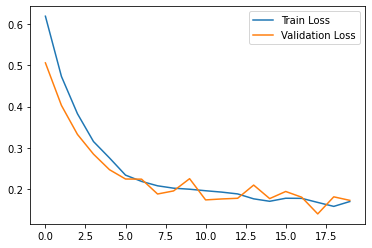

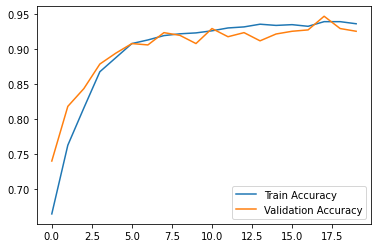

In [178]:
plt.figure()
plt.plot(history7.history["loss"],label = "Train Loss")
plt.plot(history7.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history7.history["accuracy"],label = "Train Accuracy")
plt.plot(history7.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.show()

## Model 8

In [250]:
model = Sequential()
model.add(pretrained)

# freeze the pretrained layers so they do not learn during fitting
for layer in model.layers:
    layer.trainable=False 

In [251]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_34 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_106 (Dense)            (None, 128)               262272    
_________________________________________________________________
dropout_65 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_66 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 128)             

In [252]:
model.compile(loss='binary_crossentropy',
            optimizer= Adam(1e-4),
            metrics=['accuracy'])

In [253]:
history8 = model.fit_generator(training_generator,
                               steps_per_epoch=4695//32,
                               epochs =20,
                               validation_data = validation_generator,
                               validation_steps= 521//32#,
                               #callbacks=[early_stopping]
                              )

Epoch 1/20
146/146 [==============================] - 116s 798ms/step - loss: 0.5511 - accuracy: 0.7321 - val_loss: 0.4765 - val_accuracy: 0.7734
Epoch 2/20
146/146 [==============================] - 77s 530ms/step - loss: 0.4333 - accuracy: 0.7772 - val_loss: 0.3845 - val_accuracy: 0.8281
Epoch 3/20
146/146 [==============================] - 77s 528ms/step - loss: 0.3367 - accuracy: 0.8458 - val_loss: 0.2978 - val_accuracy: 0.8789
Epoch 4/20
146/146 [==============================] - 78s 532ms/step - loss: 0.2846 - accuracy: 0.8803 - val_loss: 0.2341 - val_accuracy: 0.9004
Epoch 5/20
146/146 [==============================] - 78s 531ms/step - loss: 0.2526 - accuracy: 0.8962 - val_loss: 0.2691 - val_accuracy: 0.8809
Epoch 6/20
146/146 [==============================] - 78s 533ms/step - loss: 0.2318 - accuracy: 0.9095 - val_loss: 0.2407 - val_accuracy: 0.9043
Epoch 7/20
146/146 [==============================] - 77s 530ms/step - loss: 0.2256 - accuracy: 0.9097 - val_loss: 0.2110 - val_a

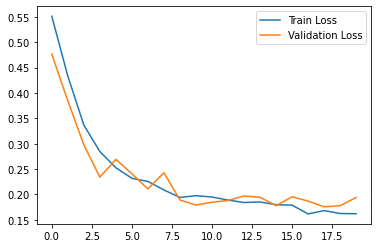

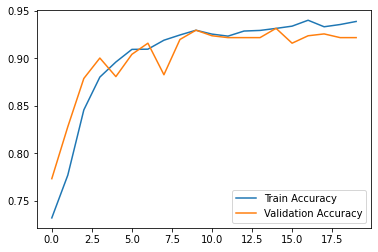

In [254]:
plt.figure()
plt.plot(history8.history["loss"],label = "Train Loss")
plt.plot(history8.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history8.history["accuracy"],label = "Train Accuracy")
plt.plot(history8.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.show()

In [255]:
print('Acuracy of the model is: ',model.evaluate_generator(test_generator)[1]*100,'%')
print('Loss of the model is: ', model.evaluate_generator(test_generator)[0])

Acuracy of the model is:  90.54487347602844 %
Loss of the model is:  0.2702328860759735


In [213]:
from sklearn.metrics import classification_report

print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.33      0.35       234
           1       0.62      0.67      0.65       390

    accuracy                           0.54       624
   macro avg       0.50      0.50      0.50       624
weighted avg       0.53      0.54      0.54       624



In [311]:
y_pred = model.predict(test_generator)

In [312]:
y_pred

array([[0.02261612],
       [0.14310354],
       [0.01579651],
       [0.04034811],
       [0.0152773 ],
       [0.01226014],
       [0.07751867],
       [0.08771351],
       [0.2715893 ],
       [0.01433411],
       [0.01958933],
       [0.0966374 ],
       [0.08852327],
       [0.01876763],
       [0.04471651],
       [0.04519859],
       [0.9313504 ],
       [0.02482915],
       [0.02668285],
       [0.01624143],
       [0.08958155],
       [0.0598242 ],
       [0.05193606],
       [0.03561306],
       [0.01420408],
       [0.00586525],
       [0.00761625],
       [0.00785607],
       [0.01960436],
       [0.04204282],
       [0.03595111],
       [0.00866732],
       [0.01451385],
       [0.02439976],
       [0.04383114],
       [0.03982782],
       [0.06209347],
       [0.03992966],
       [0.03070512],
       [0.05661854],
       [0.12995064],
       [0.05320582],
       [0.2175749 ],
       [0.01417026],
       [0.19090518],
       [0.95759046],
       [0.94916856],
       [0.238

In [313]:
y_predict = np.array([np.round(x) for x in y_pred])
y_predict

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [314]:
y_predict.shape

(624, 1)

In [315]:
y_true = np.expand_dims(test_generator.classes, axis =1)
y_true.shape

(624, 1)

In [316]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [317]:
y_true

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

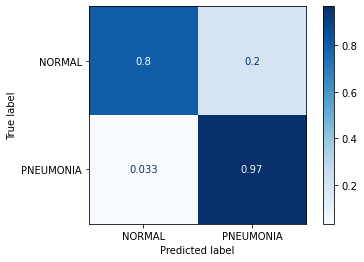

In [380]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#y_pred = model.predict(test_generator)
#y_pred = np.argmax(y_pred, axis=1) # play around
cmat = confusion_matrix(y_true, y_predict, normalize='true')
cmd = ConfusionMatrixDisplay(cmat, display_labels=test_generator.class_indices)
cmd.plot(cmap='Blues')